### Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

consumption = pd.read_excel('../../Data/Consumption/Consumption_matrix.xlsx', index_col = 0) * 0.01
consumption.index = pd.date_range(start = '2000-01-01', end='2023-11-01', freq='M').strftime('%Y-%m')
consumption.index = pd.to_datetime(consumption.index)

In [2]:
consumption

,moneraty_rate,cpi_rate,ccpi_without_arg_crd_oil,ccpi_without_food_energy,retail_consumption,vehicle_consumption,credit_card_consumption,hushld_loan,mortgage_loan,credit_loan,durb_goods_sales,quas_drub_goods_sales,non_durb_goods_sales
2000-01-01,0.032,0.019,0.011,0.007,0.512,0.301,NaN,0.1014,NaN,NaN,0.447,0.105,0.108
2000-02-01,0.014,0.018,0.011,0.008,0.519,0.330,NaN,0.1004,NaN,NaN,0.541,0.095,0.091
2000-03-01,0.023,0.021,0.015,0.013,0.516,0.294,NaN,0.1005,NaN,NaN,0.383,0.100,0.092
2000-04-01,0.018,0.014,0.016,0.015,0.527,0.262,NaN,0.0996,NaN,NaN,0.335,0.125,0.116
2000-05-01,0.011,0.011,0.015,0.013,0.542,0.308,NaN,0.0996,NaN,NaN,0.376,0.112,0.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.022,0.027,0.041,0.035,1.064,1.192,0.679257,0.0481,0.0426,0.0647,0.083,-0.022,-0.005
2023-07-01,0.025,0.023,0.039,0.033,1.030,1.045,0.696183,0.0480,0.0428,0.0652,0.014,-0.059,-0.019
2023-08-01,0.022,0.034,0.039,0.033,1.027,1.020,NaN,0.0483,0.0431,0.0653,-0.019,-0.071,-0.056
2023-09-01,0.025,0.037,0.038,0.033,1.029,1.028,NaN,0.0490,0.0435,0.0659,-0.029,-0.079,0.004


#### GDP consumption

In [3]:
gdp_c = pd.read_excel('../../Data/Consumption/gdp_consumption.xlsx', index_col = 0) * 0.01
gdp_c.index = pd.date_range(start = '1960-01-01', end='2023-11-01', freq='Q').strftime('%Y-%m')
gdp_c.index = pd.to_datetime(gdp_c.index)
gdp_c = gdp_c.loc['2000':]

In [4]:
gdp_c['consumption_rate']

2000-03-01    0.132
2000-06-01    0.117
2000-09-01    0.079
2000-12-01    0.050
2001-03-01    0.029
              ...  
2022-09-01    0.052
2022-12-01    0.033
2023-03-01    0.046
2023-06-01    0.016
2023-09-01    0.003
Name: consumption_rate, Length: 95, dtype: float64

#### 결측월 채우기

In [5]:
from statsmodels.tsa.interp.denton import dentonm

estimated = pd.Series(
    dentonm(consumption['cpi_rate'].cumsum(), gdp_c['consumption_rate'].cumsum(), freq = "qm")*3,
    index = consumption.index,
    name = 'estimated_consumption'
)

In [6]:
consumption_matrix = pd.concat(
    [
        consumption,
        estimated.diff()
    ],
    axis = 1
)

In [7]:
consumption_matrix = consumption_matrix[1:-1]

In [8]:
consumption_matrix.dropna(axis = 1, inplace = True)

In [9]:
# consumption_matrix.to_csv('../../Cleaned_Data/consumption.csv')

#### Primary Modeling

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X = consumption_matrix.iloc[:,:-1]
y = consumption_matrix['estimated_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

model = RandomForestRegressor(n_estimators = 1000, 
                              random_state = 42,
                              criterion = 'squared_error',
                              max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9.053878897734973e-05


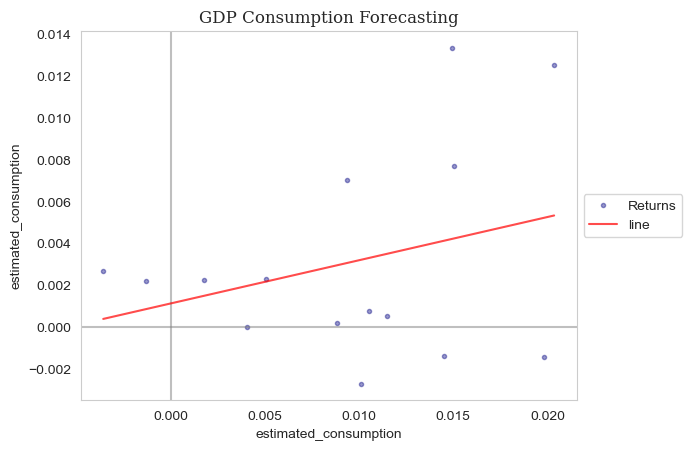

In [20]:
import seaborn as sns
beta, alpha = np.polyfit(x = y_test , y = y_pred ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y = y_pred, x = y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('GDP Consumption Forecasting', fontfamily = 'Serif')
plt.grid(False)
plt.show()

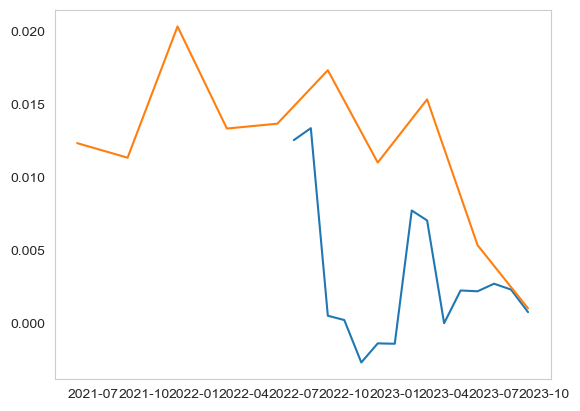

In [23]:
plt.plot(pd.Series(y_pred, index = X_test.index))
plt.plot(gdp_c['consumption_rate'][-10:].dropna() / 3)
plt.grid(False)

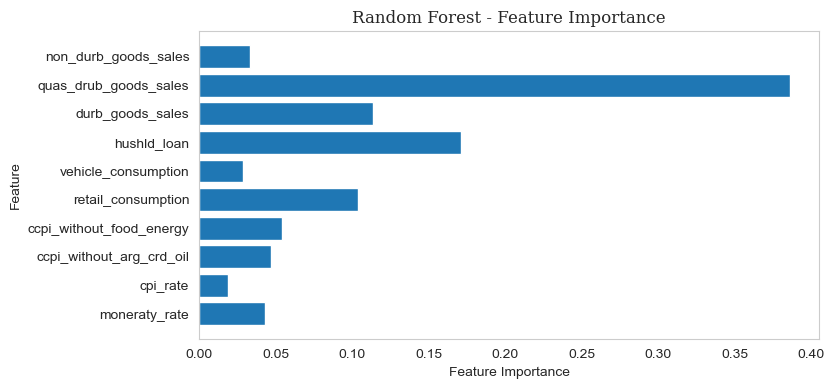

In [13]:
importance = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize = (8, 4))
plt.barh(range(len(importance)), importance, align="center")
plt.yticks(np.arange(len(importance)), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.title("Random Forest - Feature Importance", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [14]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(model, X_train, y_train, n_repeats = 30, random_state = 42)
feature_names = X_train.columns

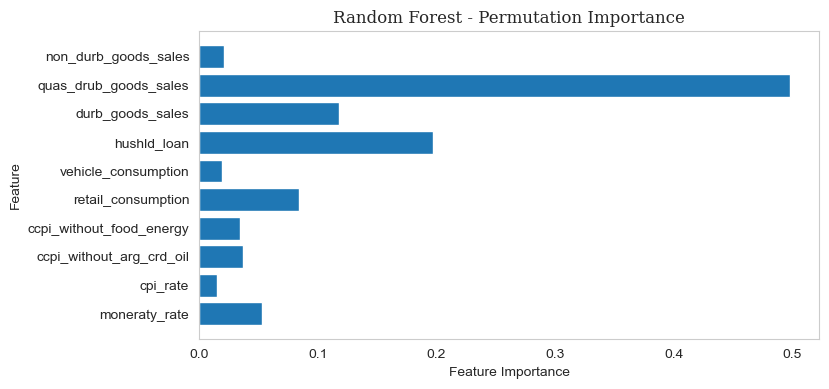

In [15]:
plt.figure(figsize = (8, 4))
plt.barh(range(len(importance['importances_mean'])), importance['importances_mean'], align="center")
plt.yticks(np.arange(len(importance['importances_mean'])), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.title("Random Forest - Permutation Importance", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [16]:
import shap

X = consumption_matrix.iloc[:,:-1]
y = consumption_matrix['estimated_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

explainer_randomforest_reg = shap.TreeExplainer(model)

shap_values_train = explainer_randomforest_reg(X_train)
shap_values_test = explainer_randomforest_reg(X_test)
shap_values_all = explainer_randomforest_reg(X)

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


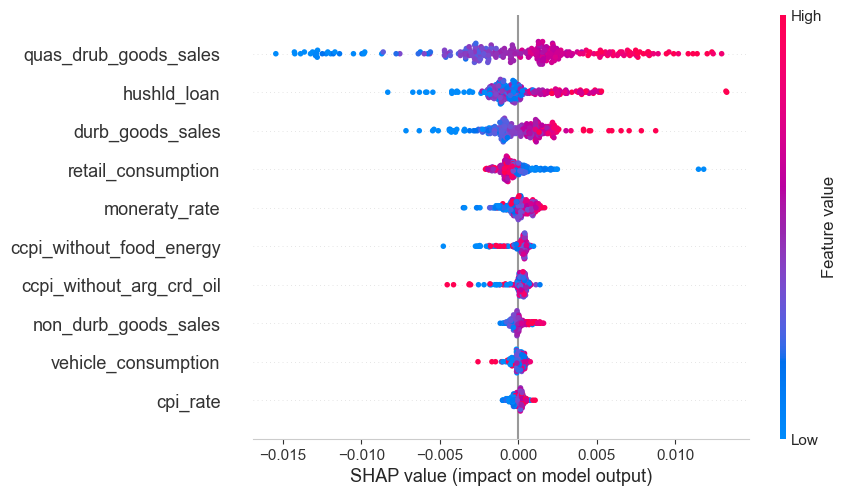

In [17]:
plt.grid(False)
shap.plots.beeswarm(shap_values_train, max_display = len(shap_values_train.feature_names))

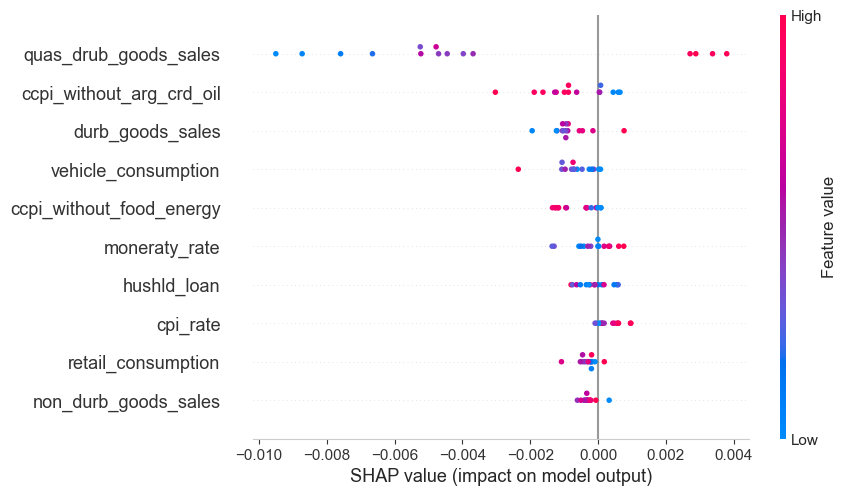

In [18]:
plt.grid(False)
shap.plots.beeswarm(shap_values_test, max_display = len(shap_values_train.feature_names))

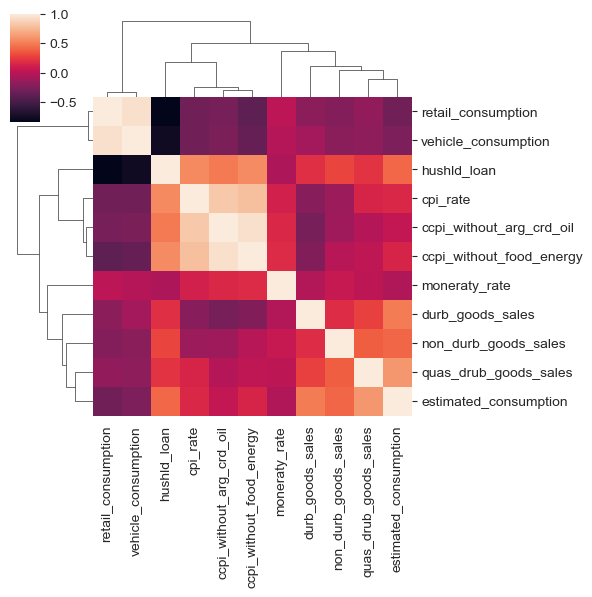

In [19]:
import seaborn as sns

sns.clustermap(consumption_matrix.corr(), figsize = (6,6))